---
**Module 1 Final Project Submission**

* Student name: **Ru Keïn**
* Student pace: **Full-Time**
* Project review date/time: **November 1, 2019 at 10:00 AM PST**
* Instructor name: **James Irving, PhD**
* Blog post URL: www.hakkeray.com/datascience/projects/king-county-housing-data

**GOAL**
* How 

**OBJECTIVES**
* Identify null, missing, duplicate, and unreliable values in the data.
* Determine best approach for analyzing each predictor: continuous vs. categorical values
* Identify which combination of features (X) are the best predictors of the target (y). 

**QUESTIONS**
* Analyze Duplicates - is there a trend within houses re-sold for higher prices?
* 

---
# OBTAIN
* Import requisite libraries and data
* Inspect columns, dataypes
    * df.head()

In [2]:
# import PyPi package for cohort libraries using shortcut
#!pip install -U fsds_100719 # comment out after install so it won't run again
import fsds_100719 as fs
from fsds_100719.imports import *
plt.style.use('seaborn')
#inline_rc = dict(mpl.rcParams)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

fsds_1007219  v0.4.8 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 
> For convenient loading of standard modules use: `>> from fsds_100719.imports import *`



Package,Handle,Description
IPython.display,dp,Display modules with helpful display and clearing commands.
fsds_100719,fs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


In [3]:
#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')

# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [40]:
# import dataset and review data types, columns, values
df = pd.read_csv('kc_house_data.csv') 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


---
# SCRUB 

**Q1: How should we address datatype of each feature to prepare it for EDA?**
    + 1. find and replace nulls
    + 2. re-cast datatypes (continuous, binary, categorical)
    + 3. check for duplicate observations (rows)
    + 4. preliminary analysis and visualizations
    + 5. decide which columns and rows to drop before EDA

    Custom Functions: 
    * hot_stats()
    * null_hunter()
    * corr_dict()

In [96]:
# HOT_STATS() function: display statistical summaries of a feature column
def hot_stats(data, column, verbose=False, target=None):
    """
    v.1.0
    Scans the values of a column within a dataframe
    and displays its datatype, nulls (incl. pct of total), 
    unique values, non-null value counts, as well as 
    statistical info if the datatype is numeric.
    
    Args:
    data: a dataframe
    
    column: a column within the data you want to scan *should be inside quotes ''
    
    KWargs:
    
    verbose: (optional) accepts a boolean (default=False). 
              verbose=True will display all unique values found.   
    
    target: (optional) accepts column name similar to column arg. 
             calculates correlation coefficient between feature and target using pandas data.corr() function. 
    
    example: 
    hot_stats(df, 'price')
    data = df
    column = 'price'
    
    Developer notes: additional features to add to v2 might
    include:
    -mode finder (frequency dict)
    -more functionality for string objects
    -side by side comparison between two features
    -OR ability to pass multiple columns at once and display all
    """
    # assigns variables to call later as shortcuts 
    feature = data[column]
    rdash = "-------->"
    ldash = "<--------"

    # figure out which hot_stats to display based on dtype 
    if feature.dtype == 'float':
        hot_stats = feature.describe().round(2)
    elif feature.dtype == 'int':
        hot_stats = feature.describe()
    elif feature.dtype == 'object' or 'category':
        hot_stats = feature.agg(['min','median','max'])
    else:
        hot_stats = None

    # display statistics (returns different info depending on datatype)
    print(rdash)
    print("HOT!STATS")
    print(ldash)
    # display column name formatted with underline
    print(f"\n{feature.name.upper()}")  
    # display the data type
    print(f"Data Type: {feature.dtype}\n")
    print(hot_stats)
    
    
    # find nulls and display total count and percentage
    if feature.isna().sum() > 0:  
        print(f"Found\n{feature.isna().sum()} Nulls out of {len(feature)}({round(feature.isna().sum()/len(feature)*100,2)}%)\n")
    else:
        print("\nNo Nulls Found!\n")
    
    # display value counts (non-nulls)
    print(f"Non-Null Value Counts:\n{feature.value_counts()}\n")
    
    # display count of unique values
    print(f"# Unique Values: {len(feature.unique())}\n")
    # displays all unique values found if verbose set to true
    if verbose == True:
        print(f"Unique Values:\n {feature.unique()}\n")
        
    # display correlation coefficient with target
    if target != None:
        corr = feature.corr(data[target]).round(4)
        print(f"Correlation with {target.upper()}: {corr}")

In [9]:
# NULL_HUNTER() function: display Null counts per column/feature
def null_hunter(df):
    print(f"Columns with Null Values")
    print("------------------------")
    for column in df:
        if df[column].isna().sum() > 0:
            print(f"{df[column].name}: \n{df[column].isna().sum()} out of {len(df[column])} ({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")

In [10]:
# CORRCOEF_DICT() function: calculates correlation coefficients assoc. with features and stores in a dictionary
def corr_dict(X, y):
    corr_coefs = []
    for x in X:
        corr = df[x].corr(df[y])
        corr_coefs.append(corr)
    
    corr_dict = {}
    
    for x, c in zip(X, corr_coefs):
        corr_dict[x] = c
    return corr_dict

In [400]:
# SUB_SCATTER() function: pass list of features (x_cols) and compare against target (or another feature)
def sub_scatter(data, x_cols, y, color=None, nrows=None, ncols=None):
    """
    Desc: displays set of scatterplots for multiple columns or features of a dataframe.
    pass in list of column names (x_cols) to plot against y-target (or another feature for 
    multicollinearity analysis)
    
    args: data, x_cols, y
    
    kwargs: color (default is magenta (#C839C5))
    
    example:
    
    x_cols = ['col1', 'col2', 'col3']
    y = 'col4'
    
    sub_scatter(df, x_cols, y)
    
    example with color kwarg:
    sub_scatter(df, x_cols, y, color=#)
    
    alternatively you can pass the column list and target directly:
    sub_scatter(df, ['col1', 'col2', 'col3'], 'price')

    """   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
    for x_col, ax in zip(x_cols, axes):
        data.plot(kind='scatter', x=x_col, y=y, ax=ax, color='#C839C5')

**FIRST GLANCE - Items to note**
    * There are 2 object datatypes that contain numeric values : 'date', 'sqft_basement'
    * The total value count is 21597. Some columns appear to be missing a substantial amount of data 
    (waterfront and yr_renovated).

In [41]:
# Display information about the variables, columns and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Before going further, a little house-keeping is in order. Let's breakdown the columns into groups based on feature-type as they relate to a real estate market context:

*Dependent Variable:*

TARGET
**price**

*Independent Variables:*

INTERIOR
**bedrooms, bathrooms, floors**

SIZE (SQUARE FOOTAGE)
**sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15**

LOCATION
**zipcode, lat, long, waterfront**

QUALITY
**condition, grade, yr_built, yr_renovated**

ANALYTICS
**date, id, view**

## Null Hunting (null_hunter)

    Let's start by hunting for nulls and then decide how to address each one (remove or replace) 
    in a manner that will not skew our analysis.

    NOTES:
      Drop null rows or columns as appropriate
      * df.isna().sum()
      * df.drop()
      * df.drop(['col1','col2'],axis=1)

      Coarse Binning NUMERICAL Data
      * replace with median or bin/convert to categorical
           * bin yr_built
           * bin sqft_basement
           * bin sqft_above
          
      CATEGORICAL data: 
      * make NaN own category OR replace with most common category
      * Fill in null values and recast variables for EDA
           * zipcode --> coded
           * View --> category
           * Waterfront --> boolean
           * yr_renovated --> is_reno (boolean)

In [42]:
null_hunter(df)            

Columns with Null Values
------------------------
waterfront: 
2376 out of 21597 (11.0%)

view: 
63 out of 21597 (0.29%)

yr_renovated: 
3842 out of 21597 (17.79%)



    Before deciding how to handle nulls in the 3 columns above, let's take a closer look at each one and go from there.

## Data Casting (hot_stats)

### Binaries (Boolean)

    Although waterfront, yr_renovated, and view all contain numeric values, if we consider what each of them represents, they're more likely to be useful to the analysis if we convert them into binaries (is renovated or not, is waterfront or not, was viewed or not).

#### ['waterfront']

In [75]:
hot_stats(df, 'waterfront')

--------->
HOT STATS
<--------

WATERFRONT
Data Type: float64

count    21597.00
mean         0.01
std          0.08
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: waterfront, dtype: float64

No Nulls Found!

Non-Null Value Counts:
0.0    21451
1.0      146
Name: waterfront, dtype: int64

# Unique Values: 2



In [44]:
# This really should be a boolean (property either is waterfront or is not waterfront)

# Fill nulls with most common value (0.0) # float value
df['waterfront'].fillna(0.0, inplace=True)
#  verify changes
df['waterfront'].isna().sum()

0

In [45]:
# Convert datatype to boolean (values can be either 0 or 1)
df['is_waterfront'] = df['waterfront'].astype('bool')
# verify
df['is_waterfront'].value_counts()

False    21451
True       146
Name: is_waterfront, dtype: int64

#### ['yr_renovated']

In [46]:
hot_stats(df, 'yr_renovated')

--------->
HOT STATS
<--------

YR_RENOVATED
Data Type: float64

count    17755.00
mean        83.64
std        399.95
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       2015.00
Name: yr_renovated, dtype: float64
Found
3842 Nulls out of 21597(17.79%)

Non-Null Value Counts:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

# Unique Values: 71



In [47]:
# This feature is also heavily skewed with zero values. 
# It should also be treated as a boolean since a property is either renovated or it's not).

# fill nulls with most common value (0)
df['yr_renovated'].fillna(0.0, inplace=True) # use float value to match current dtype

# verify change
df['yr_renovated'].isna().sum()

0

In [48]:
# Use numpy arrays to create binarized column 'is_renovated'
is_renovated = np.array(df['yr_renovated'])
is_renovated[is_renovated >= 1] = 1
df['is_renovated'] = is_renovated

In [49]:
df['is_renovated'].value_counts()

0.0    20853
1.0      744
Name: is_renovated, dtype: int64

In [50]:
# Convert to boolean
df['is_renovated'] = df['is_renovated'].astype('bool')

# verify
df['is_renovated'].value_counts()

False    20853
True       744
Name: is_renovated, dtype: int64

#### ['view']

In [51]:
hot_stats(df, 'view')

--------->
HOT STATS
<--------

VIEW
Data Type: float64

count    21534.00
mean         0.23
std          0.77
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          4.00
Name: view, dtype: float64
Found
63 Nulls out of 21597(0.29%)

Non-Null Value Counts:
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

# Unique Values: 6



In [52]:
# Once again, almost all values are 0 .0

# replace nulls with most common value (0). 
df['view'].fillna(0, inplace=True)

#verify
df['view'].isna().sum()

0

    Since view has a finite set of values (0 to 4) we could assign category codes. However, considering the high number of zeros, it makes more sense to binarize the values into a new column representing whether or not the property was viewed.

In [53]:
# create new boolean column for view:
df['viewed'] = df['view'].astype('bool')

# verify
df['viewed'].dtype

dtype('bool')

In [54]:
binaries = ['is_waterfront', 'is_renovated', 'viewed']

binaries_dict = corr_dict(binaries, 'price')
binaries_dict

{'is_waterfront': 0.2643062804831157,
 'is_renovated': 0.11754308700194362,
 'viewed': 0.3562431893938032}

    None of these correlation values look strong enough to be predictive of price.

### Categories - Nominal

#### ['floors']

In [97]:
hot_stats(df, 'floors', target='price')

-------->
HOT!STATS
<--------

FLOORS
Data Type: float64

count    21597.00
mean         1.49
std          0.54
min          1.00
25%          1.00
50%          1.50
75%          2.00
max          3.50
Name: floors, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

# Unique Values: 6

Correlation with PRICE: 0.2568


    Although you could theoretically have any number of floors, this really should be treated as a category 
    (i.e. contains finite possible values). Assuming this is probably true for the other interior features 
    (bedrooms, bathrooms). Let's look at a scatter plot using the sub_scatter function.

In [68]:
# pass a list of features into xcols and compare against the target (or another feature)

#def sub_scatter(x_cols, y):
#    fig, axes = plt.subplots(nrows=len(x_cols)%2, ncols=len(x_cols), figsize=(16,4))
#    for x_col, ax in zip(x_cols, axes):
#        df.plot(kind='scatter', x=x_col, y=y, ax=ax, color='#C839C5')

TypeError: zip argument #2 must support iteration

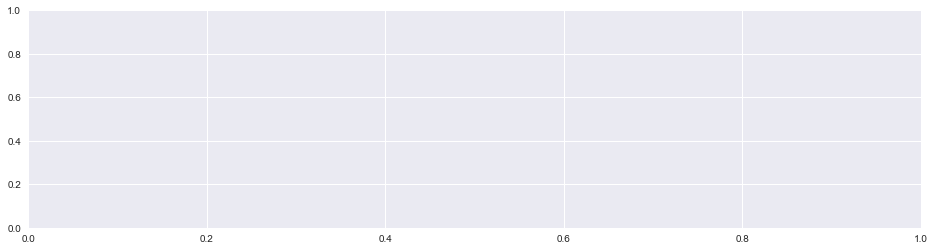

In [269]:
y = 'price'
x_cols = ['floors','bedrooms', 'bathrooms']

sub_scatter(df, x_cols, y)

     Bathrooms appears to have a very linear relationship with price. Bedrooms is somewhat linear up to a certain
     point. Let's look at the hot stats for both.

#### ['bedrooms']

In [112]:
hot_stats(df, 'bedrooms', target='price')

-------->
HOT!STATS
<--------

BEDROOMS
Data Type: int64

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

No Nulls Found!

Non-Null Value Counts:
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Unique Values: 12

Correlation with PRICE: 0.3088


As expected, insignificant correlation with price.

#### ['bathrooms']

In [113]:
hot_stats(df, 'bathrooms', target='price')

-------->
HOT!STATS
<--------

BATHROOMS
Data Type: float64

count    21597.00
mean         2.12
std          0.77
min          0.50
25%          1.75
50%          2.25
75%          2.50
max          8.00
Name: bathrooms, dtype: float64

No Nulls Found!

Non-Null Value Counts:
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

# Unique Values: 29

Correlation with PRICE: 0.5259


In [115]:
# Create category columns for interior features: floors, bedrooms, and bathrooms
df['floor_cat'] = df['floors'].astype('category')
df['bedroom_cat'] = df['bedrooms'].astype('category')
df['bathroom_cat'] = df['bathrooms'].astype('category')

In [119]:
# check correlation coefficients of interior feature categories with price and save to dict
indoor_cats = ['floor_cat', 'bedroom_cat', 'bathroom_cat']

indoor_cats_dict = corr_dict(indoor_cats, 'price')
indoor_cats_dict

{'floor_cat': 0.2568035370080218,
 'bedroom_cat': 0.30878747195653283,
 'bathroom_cat': 0.5259056214532012}

    Bathrooms is the only feature showing correlation over the 0.5 threshold. We can probably drop the other two as predictor candidates.

### Categories - Ordinal

#### ['condition']

In [230]:
hot_stats(df, 'condition', target='price')

-------->
HOT!STATS
<--------

CONDITION
Data Type: int64

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

No Nulls Found!

Non-Null Value Counts:
3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

# Unique Values: 5

Correlation with PRICE: 0.0361


In [228]:
# Condition should be treated as ordinal since there is a relationship between the values (ranked 1 to 5)
cat_dtype = pd.api.types.CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)

# Recast condition as an ordered category
df['condition'] = df['condition'].astype('int')

# verify
df['condition'].dtype

dtype('int64')

#### ['grade']

In [231]:
# View grade stats
hot_stats(df, 'grade', target='price')

-------->
HOT!STATS
<--------

GRADE
Data Type: int64

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

No Nulls Found!

Non-Null Value Counts:
7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

# Unique Values: 11

Correlation with PRICE: 0.668


In [229]:
# Grade should also be treated as ordinal since it is a ranked scale like condition

# create ranking scale from 1 to 13
cat_dtype = pd.api.types.CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ordered=True)

# Recast as an ordered category
df['grade'] = df['grade'].astype('int')

# verify
df['grade'].dtype

dtype('int64')

In [239]:
ordinal_cats = ['condition', 'grade', 'yr_built']

ordinal_dict = corr_dict(quality_cats, 'price')

ordinal_dict

{'condition': 0.036056375486095034, 'grade': 0.6679507713876452}

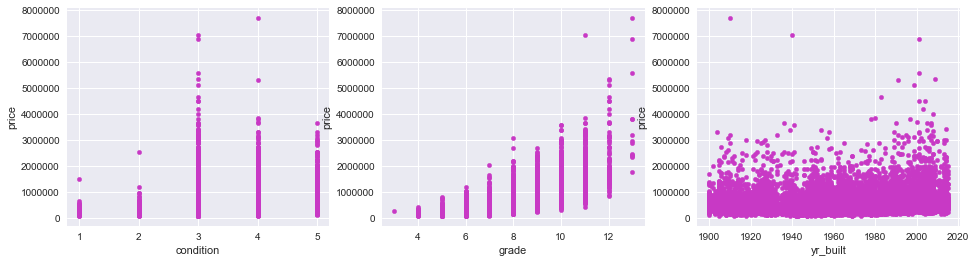

In [273]:
y = 'price'
x_cols = ['condition', 'grade', 'yr_built']

sub_scatter(df, x_cols, y)

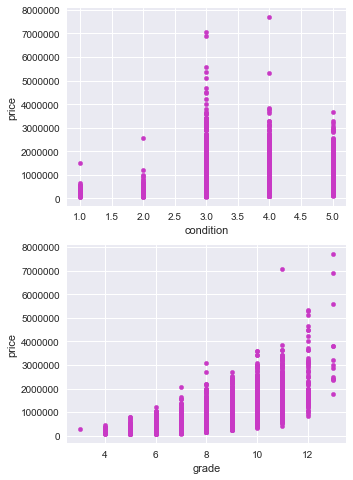

In [274]:
y = 'price'
x_cols = ['condition', 'grade']

sub_scatter(df, x_cols, y)

    Condition is useless, but grade is our highest coefficient so far at 0.68! 
    We can also see a very nice positive linear relationship between grade and price. 

#### ['yr_built'] 

In [120]:
hot_stats(df, 'yr_built', target='price')

-------->
HOT!STATS
<--------

YR_BUILT
Data Type: int64

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

No Nulls Found!

Non-Null Value Counts:
2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

# Unique Values: 116

Correlation with PRICE: 0.054


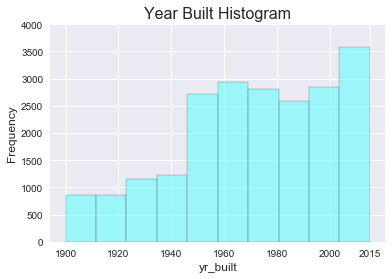

In [121]:
# Let's look at the data distribution of yr_built values 

fig, ax = plt.subplots()
df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
xticks = (1900, 1920, 1940, 1960, 1980, 2000, 2015)
yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
plt.xticks(xticks);
plt.yticks(yticks);
ax.set_title('Year Built Histogram', fontsize=16)
ax.set_xlabel('yr_built', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

In [122]:
# Most houses were built during the second half of the century (after 1950)
# Let’s create a more normalized distribution by creating adaptive bins based on yr_built:

# define a binning scheme with custom ranges based on quantiles
quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['yr_built'].quantile(quantile_list)

quantiles # 1900, 1951, 1975, 1997, 2015

0.00    1900.0
0.25    1951.0
0.50    1975.0
0.75    1997.0
1.00    2015.0
Name: yr_built, dtype: float64

In [123]:
# Bin the years in to ranges based on the quantiles.
# label the bins for each value 
# store the yr_range and its corresponding yr_label as new columns in df

yb_bins = [1900, 1951, 1975, 1997, 2015]

yb_labels = [1, 2, 3, 4]

# create a new column for the category range values
df['yb_range'] = pd.cut(df['yr_built'], bins=yb_bins)

# create a new column for the category labels
df['yb_cat'] = pd.cut(df['yr_built'], bins=yb_bins, labels=yb_labels)

In [124]:
# view the binned features corresponding to each yr_built 
df[['yr_built','yb_cat', 'yb_range']].iloc[9003:9007] # picking a random index location

,yr_built,yb_cat,yb_range
9003,1996,3,"(1975, 1997]"
9004,1959,2,"(1951, 1975]"
9005,2003,4,"(1997, 2015]"
9006,1902,1,"(1900, 1951]"


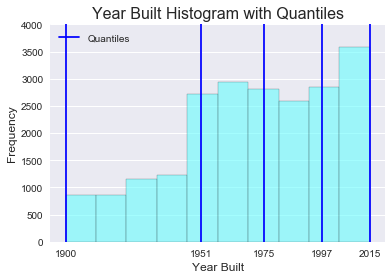

In [125]:
# Let’s look at the original distribution histogram again with the quantiles added:

fig, ax = plt.subplots()

df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='b')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    xticks = quantiles
    yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
    plt.xticks(xticks);
    plt.yticks(yticks);
    ax.set_title('Year Built Histogram with Quantiles',fontsize=16)
    ax.set_xlabel('Year Built', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

In [126]:
# values look much more normally distributed between the new categories
df.yb_cat.value_counts()

2    5515
3    5411
1    5326
4    5258
Name: yb_cat, dtype: int64

Text(0, 0.5, 'Frequency')

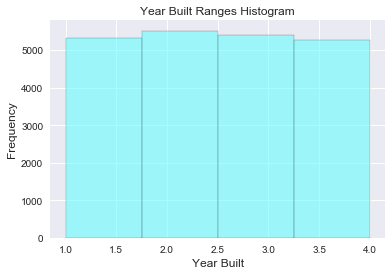

In [127]:
# visualize the distribution of the binned values

fig, ax = plt.subplots()
df['yb_cat'].hist(bins=4, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
ax.set_title('Year Built Ranges Histogram', fontsize=12)
ax.set_xlabel('Year Built', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [128]:
# get_dummies for one-hot encoding
yb_dummies = pd.get_dummies(df['yb_cat'], prefix='yb', drop_first=True)

In [129]:
df = pd.concat([df, yb_dummies], axis=1)

#### ['zipcode']

In [210]:
hot_stats(df, 'zipcode')

-------->
HOT!STATS
<--------

ZIPCODE
Data Type: int64

count    21597.000000
mean     98077.951845
std         53.513072
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64

No Nulls Found!

Non-Null Value Counts:
98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

# Unique Values: 70



Text(0, 0.5, 'Frequency')

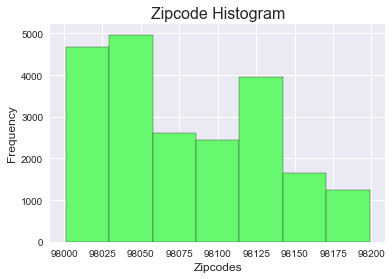

In [133]:
# There are 70 unique zipcode values
# Let's look at the data distribution of zipcode values 
fig, ax = plt.subplots()
df['zipcode'].hist(bins=7, color='#67F86F',
edgecolor='black', grid=True)
ax.set_title('Zipcode Histogram', fontsize=16)
ax.set_xlabel('Zipcodes', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [134]:
# Let’s define a binning scheme with custom ranges for the zipcode values 
# The bins will be created based on quantiles

quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['zipcode'].quantile(quantile_list)

quantiles # 98001, 98033, 98065, 98118, 98199

0.00    98001.0
0.25    98033.0
0.50    98065.0
0.75    98118.0
1.00    98199.0
Name: zipcode, dtype: float64

In [158]:
# Now we can label the bins for each value and store both the bin range 
# and its corresponding label.

zip_bins = [98000, 98033, 98065, 98118, 98200]

zip_labels = [1, 2, 3, 4]

df['zip_range'] = pd.cut(df['zipcode'], bins=zip_bins)

df['zip_cat'] = pd.cut(df['zipcode'], bins=zip_bins, labels=zip_labels)

# view the binned features 
df[['zipcode','zip_cat', 'zip_range']].iloc[9000:9005] # pick a random index

,zipcode,zip_cat,zip_range
9000,98092,3,"(98065, 98118]"
9001,98117,3,"(98065, 98118]"
9002,98144,4,"(98118, 98200]"
9003,98038,2,"(98033, 98065]"
9004,98004,1,"(98000, 98033]"


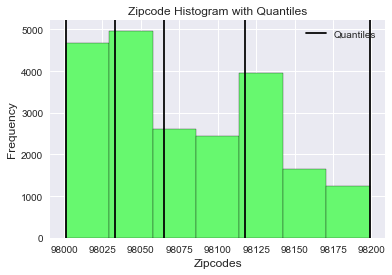

In [159]:
# visualize the quantiles in the original distribution histogram

fig, ax = plt.subplots()

df['zipcode'].hist(bins=7, color='#67F86F', edgecolor='black', grid=True)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='black')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title('Zipcode Histogram with Quantiles',fontsize=12)
    ax.set_xlabel('Zipcodes', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

#### ['lat']  ['long']

    The coordinates for latitude and longitude are not going to be useful to us since we already have zipcodes as a geographic identifier.  

In [113]:
# lmplot

#68FDFE = cyan
#20C5C6 = lightcyan
#67F86F = lightgreen
#FD6F6B = lightred
#FD7CFC = magenta

---
### Objects
We need to convert the datatypes of numeric values currently stored as objects. This will allow us to include them in the preliminary exploration and analysis. 

    * date -> recast as datetime
    * sqft_basement -> recast as float

#### ['date'] 
convert to datetime

In [211]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

In [212]:
hot_stats(df, 'date')

-------->
HOT!STATS
<--------

DATE
Data Type: datetime64[ns]

min   2014-05-02
max   2015-05-27
Name: date, dtype: datetime64[ns]

No Nulls Found!

Non-Null Value Counts:
2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
             ... 
2014-07-27      1
2015-03-08      1
2014-11-02      1
2015-05-15      1
2015-05-24      1
Name: date, Length: 372, dtype: int64

# Unique Values: 372



### Continuous

* SQUARE-FOOTAGE

Redundancy check: is there any overlap in the measurements?

* sqft_living = sqft_basement + sqft_above ?
* sqft_lot - sqft_living = sqft_above ?


**Continuous Variables:**
a continuous variable can take on any value within a range

* **sqft_living** --> highest corr : price (before transformation/scaling); most normal distribution
* sqft_lot --> not normal distribution
* sqft_living15 #Highly skewed
* sqft_lot15 #Highly skewed
* sqft_above #High corr with sqft_living
* sqft_basement #Very high number of null values --> treat '0' = no basement?


#### ['sqft_basement']

In [264]:
# let's figure out what datatype is more appropriate for sqft_basement
hot_stats(df, 'sqft_basement')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: float64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: sqft_basement, dtype: float64
Found
21597 Nulls out of 21597(100.0%)

Non-Null Value Counts:
Series([], Name: sqft_basement, dtype: int64)

# Unique Values: 1



In [265]:
# Note the majority of the values are zero...we could bin this as a binary 
# where the property either has a basement or does not...

# For now we'll replace '?'s with string value '0.0'
df['sqft_basement'].replace(to_replace='?', value='0.0', inplace=True)

In [266]:
# and change datatype to float.
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [302]:
living = df['sqft_living']
above = df['sqft_above']
basement = living - above
df['sqft_basement'] = basement

In [303]:
hot_stats(df, 'sqft_basement', target='price')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: int64

count    21597.000000
mean       291.725008
std        442.667800
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: sqft_basement, dtype: float64

No Nulls Found!

Non-Null Value Counts:
0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

# Unique Values: 306

Correlation with PRICE: 0.3238


    That's much better. Although, lot's of zeros could be a problem. Let's check out the other square-footage 
    features and see if those might be more useful.

#### ['sqft_above']

In [275]:
hot_stats(df, 'sqft_above', target='price')

-------->
HOT!STATS
<--------

SQFT_ABOVE
Data Type: int64

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

# Unique Values: 942

Correlation with PRICE: 0.6054


    Pretty decent correlation with price.

#### ['sqft_living']

In [263]:
hot_stats(df, 'sqft_living', target='price')

-------->
HOT!STATS
<--------

SQFT_LIVING
Data Type: int64

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

# Unique Values: 1034

Correlation with PRICE: 0.7019


    sqft_living shows correlation value of 0.7 with price -- our highest coefficient yet!

In [301]:
sqftint = ['sqft_living', 'sqft_above', 'basement']

sqftint_dict = corr_dict(sqftint, 'price')
sqftint_dict

{'sqft_living': 0.7019173021377595,
 'sqft_above': 0.6053679437051795,
 'basement': 0.323798906899048}

    Excellent correlation between sqft_living and price! We can probably toss out basement based on the low 
    coefficient alone.

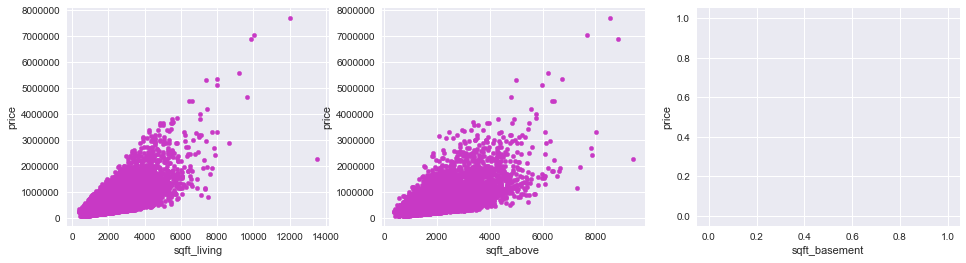

In [290]:
# Visualize the relationship between square-footages and price
sub_scatter(df, sqftint, 'price')

    sqft_living and sqft_above appear to be very similar. Let's plot them against each other to see
    if there is some covariance going on (the measurements probably overlap!)

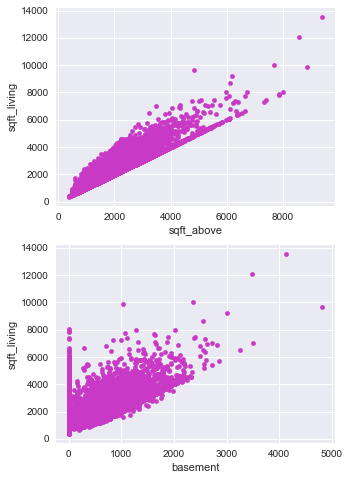

In [298]:
# Visualize multicollinearity between interior square-footages

x_cols = ['sqft_above', 'basement']
sub_scatter(df, x_cols, 'sqft_living')

In [112]:
# QUESTION: Is there any overlap in the square footage measurements?
# sqft_living == sqft_basement + sqft_above ?
# sqft_lot - sqft_living == sqft_above ?

sqft_lv = np.array(df['sqft_living'])
sqft_ab = np.array(df['sqft_above'])
sqft_bs = np.array(df['sqft_basement'])

sqft_ab + sqft_bs == sqft_lv #array([ True,  True,  True, ...,  True,  True,  True])

array([ True,  True,  True, ...,  True,  True,  True])

In [113]:
print(df['sqft_living'].iloc[0]) #1180
print(df['sqft_above'].iloc[0] + df['sqft_basement'].iloc[0]) #1180

print(df['sqft_living'].iloc[1]) #2570
print(df['sqft_above'].iloc[1] + df['sqft_basement'].iloc[1]) #2570

1180
1180.0
2570
2570.0


In [114]:
# we don't need sqft_basement or sqft_above; let's drop them and keep sqft_living
if sqft_ab.all() + sqft_bs.all() == sqft_lv.all():
    print("True")

True


#### ['sqft_lot']

#### ['sqft_lot15']
#### ['sqft_living15']

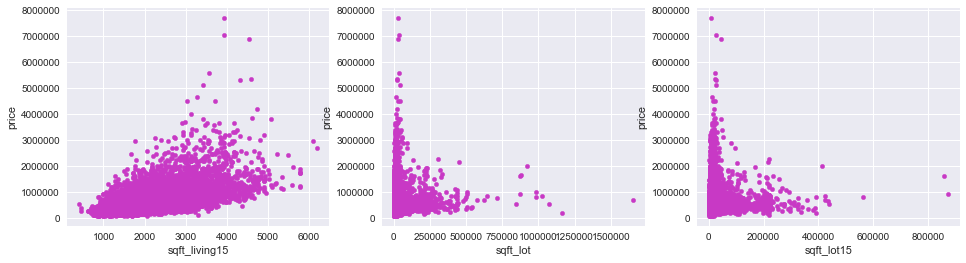

In [401]:
y = 'price'
x_cols = ['sqft_living15', 'sqft_lot', 'sqft_lot15']

sub_scatter(df, x_cols, y)

In [402]:
hot_stats(df, 'sqft_living15', target='price')

-------->
HOT!STATS
<--------

SQFT_LIVING15
Data Type: int64

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

No Nulls Found!

Non-Null Value Counts:
1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

# Unique Values: 777

Correlation with PRICE: 0.5852


In [403]:
hot_stats(df, 'sqft_lot', target='price')

-------->
HOT!STATS
<--------

SQFT_LOT
Data Type: int64

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

No Nulls Found!

Non-Null Value Counts:
5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

# Unique Values: 9776

Correlation with PRICE: 0.0899


In [405]:
hot_stats(df, 'sqft_lot15', target='price')

-------->
HOT!STATS
<--------

SQFT_LOT15
Data Type: int64

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

No Nulls Found!

Non-Null Value Counts:
5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

# Unique Values: 8682

Correlation with PRICE: 0.0828


In [406]:
sqft_ext = ['sqft_lot', 'sqft_lot15', 'sqft_living15']

sqft_ext_dict = corr_dict(sqft_ext, 'price')
sqft_ext_dict

{'sqft_lot': 0.08987622099083864,
 'sqft_lot15': 0.0828449311749643,
 'sqft_living15': 0.5852412017040663}

sqft_living15 (the square-footage of the neighbors' houses) looks to be the only one that correlates well with price. However, as we saw above, this also correlates with square-foot living, so we'd run into some multicollinearity issues if we kept both. Since sqft_living is higher, that is likely to be a better candidate for prediction.

### Index

#### ['id']

In [120]:
hot_stats(df, 'id')

--------->
HOT STATS
<--------

ID
Data Type: int64

count    2.159700e+04
mean     4.580474e+09
std      2.876736e+09
min      1.000102e+06
25%      2.123049e+09
50%      3.904930e+09
75%      7.308900e+09
max      9.900000e+09
Name: id, dtype: float64

No Nulls Found!

Non-Null Value Counts:
795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

# Unique Values: 21420



The primary key we'd use as an index for this data set would be 'id'. Our assumption therefore is that the 'id' for each observation (row) is unique. Let's do a quick scan for duplicate entries to confirm this is true.

In [121]:
# check for duplicate id's
df['id'].duplicated().value_counts() 

False    21420
True       177
Name: id, dtype: int64

In [122]:
# Looks like there are in fact some duplicate ID's! Not many, but worth investigating.

# Let's flag the duplicate id's by creating a new column 'is_dupe':
df.loc[df.duplicated(subset='id', keep=False), 'is_dupe'] = 1 # mark all duplicates 

# verify all duplicates were flagged
df.is_dupe.value_counts() # 353

1.0    353
Name: is_dupe, dtype: int64

In [123]:
# the non-duplicate rows show as null in our new column
df.is_dupe.isna().sum()

21244

In [124]:
# Replace 'nan' rows in is_dupe with 0.0
df.loc[df['is_dupe'].isna(), 'is_dupe'] = 0

# verify
df['is_dupe'].unique()

array([0., 1.])

In [125]:
# convert column to boolean data type
df['is_dupe'] = df['is_dupe'].astype('bool')
# verify
df['is_dupe'].value_counts()

False    21244
True       353
Name: is_dupe, dtype: int64

In [126]:
# Let's now copy the duplicates into a dataframe subset for closer inspection
# It's possible the pairs contain data missing from the other which 
# we can use to fill nulls identified previously.

df_dupes = df.loc[df['is_dupe'] == True]

# check out the data discrepancies between duplicates (first 3 pairs)
df_dupes.head(6)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_waterfront,is_renovated,viewed,yb_range,yb_cat,floors_cat,bedrooms_cat,bathrooms_cat,zip_range,zip_cat,is_dupe
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500,False,False,False,"(1900, 1951]",1,1.0,3,1.50,"(98065, 98118]",3,True
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500,False,False,False,"(1900, 1951]",1,1.0,3,1.50,"(98065, 98118]",3,True
313,4139480200,2014-06-18,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,False,False,True,"(1975, 1997]",3,1.0,4,3.25,"(98000, 98033]",1,True
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,False,False,True,"(1975, 1997]",3,1.0,4,3.25,"(98000, 98033]",1,True
324,7520000520,2014-09-05,232000.0,2,1.00,1240,12092,1.0,0.0,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460,False,True,False,"(1900, 1951]",1,1.0,2,1.00,"(98118, 98200]",4,True
325,7520000520,2015-03-11,240500.0,2,1.00,1240,12092,1.0,0.0,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460,False,True,False,"(1900, 1951]",1,1.0,2,1.00,"(98118, 98200]",4,True


In [127]:
# Looks like the only discrepancies might occur between 'date' and 'price' values
# Some of the prices nearly double, even when the re-sale is just a few months later!

df_dupes.loc[df_dupes['id'] == 6021501535]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_waterfront,is_renovated,viewed,yb_range,yb_cat,floors_cat,bedrooms_cat,bathrooms_cat,zip_range,zip_cat,is_dupe
93,6021501535,2014-07-25,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,False,False,False,"(1900, 1951]",1,1.0,3,1.5,"(98065, 98118]",3,True
94,6021501535,2014-12-23,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,False,False,False,"(1900, 1951]",1,1.0,3,1.5,"(98065, 98118]",3,True


In [128]:
# Set index of df_dupes to 'id'
df_dupes.set_index('id')
# Set index of df to 'id'
df.set_index('id')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_waterfront,is_renovated,viewed,yb_range,yb_cat,floors_cat,bedrooms_cat,bathrooms_cat,zip_range,zip_cat,is_dupe
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,False,False,False,"(1951, 1975]",2,1.0,3,1.00,"(98118, 98200]",4,False
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,False,True,False,"(1900, 1951]",1,2.0,3,2.25,"(98118, 98200]",4,False
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,False,False,False,"(1900, 1951]",1,1.0,2,1.00,"(98000, 98033]",1,False
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,False,False,False,"(1951, 1975]",2,1.0,4,3.00,"(98118, 98200]",4,False
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,False,False,False,"(1975, 1997]",3,1.0,3,2.00,"(98065, 98118]",3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,False,False,False,"(1997, 2015]",4,3.0,3,2.50,"(98065, 98118]",3,False
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,False,False,False,"(1997, 2015]",4,2.0,4,2.50,"(98118, 98200]",4,False
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,False,False,False,"(1997, 2015]",4,2.0,2,0.75,"(98118, 98200]",4,False


## Feature Elimination

In [407]:
# At this point we can drop the rows and columns we no longer need and begin exploring 
# the data. Let's review our current feature list and data types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 38 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
is_waterfront    21597 non-null bool
is_renovated     21597 non-null

In [130]:
# Before we start dropping, let's save a backup copy of the current df using pickle.
import pickle
# create pickle data_object
df_predrops = df

In [131]:
with open('data.pickle', 'wb') as f:
    pickle.dump(df_predrops, f, pickle.HIGHEST_PROTOCOL)

In [132]:
# import df (pre-drops) with pickle
# with open('data.pickle', 'rb') as f:
    #df2 = pickle.load(f)

In [133]:
# let's drop the first occurring duplicate rows and keep the last ones 
# (since those more accurately reflect latest market data)

# save original df.shape for comparison after dropping duplicate rows
predrop = df.shape # (21597, 28)

# first occurrence, keep last
df.drop_duplicates(subset='id', keep ='last', inplace = True) 

# verify dropped rows by comparing df.shape before and after values
print(f"predrop: {predrop}")
print(f"postdrop: {df.shape}")

predrop: (21597, 32)
postdrop: (21420, 32)


In [134]:
# create list of columns to drop (features not needed for EDA)
hot_drop = ['id', 
            'date', 
            'view', 
            'yr_renovated',
            'yr_built',
            'zipcode', 
            'lat', 
            'long', 
            'yb_range', 
            'zip_range',
            'sqft_above', 
            'sqft_basement']

In [135]:
# store hot_drop columns in separate df
df_drops = df[hot_drop].copy()

# set index of df_drops to 'id'
df_drops.set_index('id')
# verify
df_drops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 12 columns):
id               21420 non-null int64
date             21420 non-null datetime64[ns]
view             21420 non-null float64
yr_renovated     21420 non-null float64
yr_built         21420 non-null int64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
yb_range         21334 non-null category
zip_range        21420 non-null category
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
dtypes: category(2), datetime64[ns](1), float64(5), int64(4)
memory usage: 1.8 MB


In [136]:
# drop it like its hot >> df.drop(hot_drop, axis=1, inplace=True)
df.drop(hot_drop, axis=1, inplace=True)

In [408]:
# verify
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 38 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
is_waterfront    21597 non-null bool
is_renovated     21597 non-null

## Target

#### ['price']

In [138]:
# Let's take a quick look at the statistical data for our dependent variable (price):
hot_stats(df, 'price')

--------->
HOT STATS
<--------

PRICE
Data Type: float64

count      21420.00
mean      541861.43
std       367556.94
min        78000.00
25%       324950.00
50%       450550.00
75%       645000.00
max      7700000.00
Name: price, dtype: float64

No Nulls Found!

Non-Null Value Counts:
450000.0    172
350000.0    167
550000.0    157
500000.0    151
425000.0    149
           ... 
234975.0      1
804995.0      1
870515.0      1
336950.0      1
884744.0      1
Name: price, Length: 3595, dtype: int64

# Unique Values: 3595



Keeping the below numbers in mind could be helpful as we start exploring the data:

* range: 78,000 to 7,700,000
* mean value: 540,296
* median value: 450,000

# EXPLORE:
    Check distributions, outliers, etc
[ ] Check scales, ranges (df.describe())
[x] Check histograms to get an idea of distributions (df.hist()) and dat transformations to perform
Can also do kernel density estimates
[x] Use scatterplots to check for linearity and possible categorical variables (df.plot(kind-'scatter')
categoricals will look like vertical lines
[x] Use pd.plotting.scatter_matrix to visualize possible relationships
[x] Check for linearity

In [325]:
# Subset dataframe into groups for easier viewing of data via individual subplots?

categories = []




#pd.plotting.scatter_matrix(df, figsize=(20,20));

In [132]:
# Which features are best predictos?


# numeric / continuous visualizations



# categorical / discrete visualizations

## Multicollinearity
Heatmap: Absolute Correlation Matrix

##### Scrub 3: Multicollinearity

**Q3: which predictors are closely related (and should be dropped)?**
    + multicollinearity: one-hot dummy variables, data dropping
    + remove variable having most corr with largest # of variables

        * Checking for Multicollinearity
        * use seaborn to make correlation matrix plot
        * threshold >= 0.5 corr (rank correlations -- build custom function?) 
        * one-hot dummy variables, and data dropping


In [ ]:
# Pos Corr with Target (Price):
    # sqft_living: 0.7
        # grade: 0.67
        # sqft_above: 0.61
        # sqft_living15: 0.59
        # bathrooms: 0.53 

# Multicollinearity

# bathrooms: 
    # sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
    # bedrooms: 0.51
    # yr_built: 0.51
    # floors: 0.5

# sqft_living:
    # sqft_above: 0.88
    # sqft_living15: 0.76
    # grade: 0.76
    # bathrooms: 0.76
    # bedrooms: 0.58

# Grade
    #sqft_living: 0.76
    #sqft_above:  0.76
    #sqft_living15: 0.71
    #bathrooms: 0.67

# sqft_above: 
    # sqft_living: 0.88
    # sqft_living15: 0.73
    # floors: 0.52
    # grade: 0.76
        

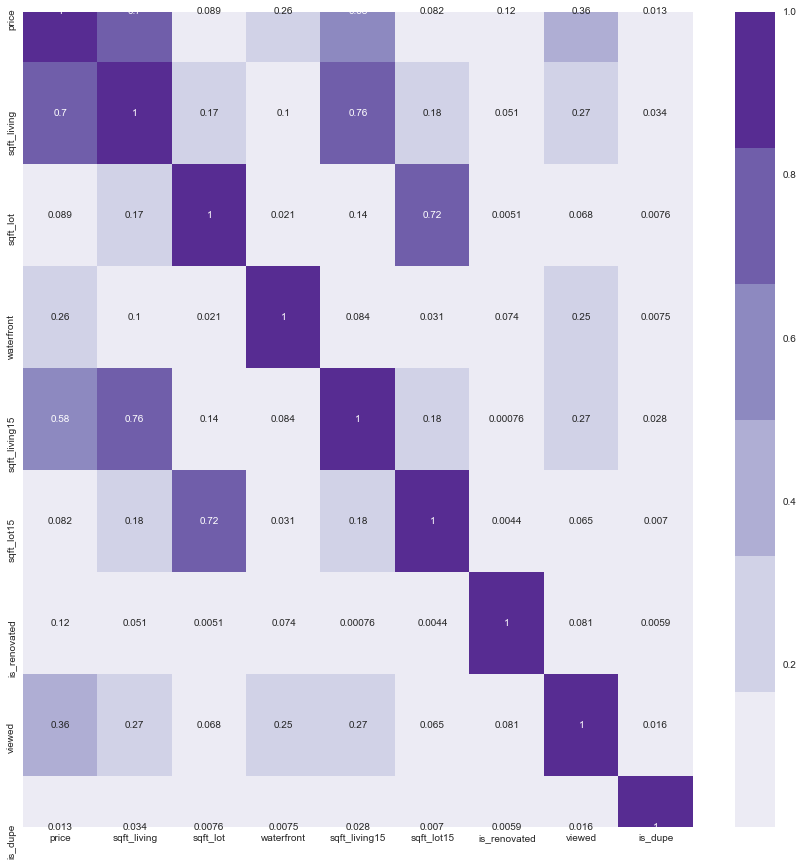

In [300]:
corr = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(data=corr.abs(), annot=True, cmap=sns.color_palette('Purples'))
plt.show()

In [27]:
# Quick correlation check with the target (price) indicates none of the columns addressed above will be useful predictors (all have correlation coefficients below 0.5)
print(df['bathrooms'].corr(df['price']))
print(df['sqft_living'].corr(df['price']))
print(df['sqft_living15'].corr(df['price']))
print(df['grade'].corr(df['price']))
print(df['view'].corr(df['price']))

0.5259056214532007
0.7019173021377598
0.5852412017040661
0.6679507713876449
0.3934966693793815


In [140]:
def plot_reg(data, feature, target):
    sns.regplot(x=feature, y=target, data=data)
    plt.show()

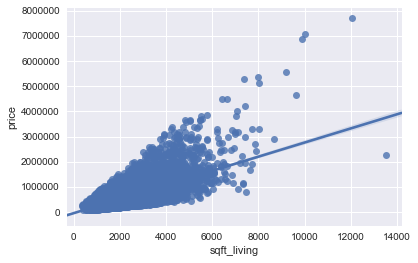

In [141]:
plot_reg(df, 'sqft_living', 'price')

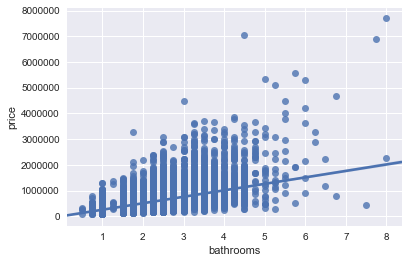

In [150]:
plot_reg(df, 'bathrooms', 'price')

In [148]:

df.grade.cat.as_ordered(inplace=True)

In [ ]:
# bathrooms: 
# sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
# bedrooms: 0.51
    # yr_built: 0.51
# floors: 0.5
y_sub = 'price'
rm_sub = ['grade','condition', 'yr_built', 'view']

sub_scatter(rm_sub, y_sub)

---
### Category Codes

In [143]:
# codify categorical features
df["yr_built"] = df["yr_built"].cat.codes
df["zc_range"] = df["zc_range"].cat.codes

#create dummy columns to store cat.codes
zipcode_dummy = pd.get_dummies(bins_zip, prefix="zip")
year_dummy = pd.get_dummies(bins_year, prefix="yr")

#drop now obsolete columns
df = df.drop(["yr_built","zipcode"], axis=1)

df = pd.concat([df, zipcode_dummy, year_dummy], axis=1)

#double check that everything is as it should be


array([98178, 98125, 98028, ..., 98144, 98027, 98144])

In [19]:
# Recast 'condition' as a category:
condition_series = df['condition']
cat_condition = condition_series.astype('category')

# get_dummies
pd.get_dummies(cat_condition)

# LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
condition_dummies = lb.fit_transform(cat_condition)

# Convert back to dataframe
condition_dum_df = pd.DataFrame(condition_dummies, columns=lb.classes_)

# Avoid Multicollinearity Trap
# One can be predicted based on others unless we drop one of the dummy cols:
pd.get_dummies(cat_condition, drop_first=True)
condition_dum_df.head(3)

,1,2,3,4,5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0


In [ ]:
# Remove category columns and replace with dummy cols:

# Create Dummies
grade_dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
condition_dummies = pd.get_dummies(df['condition'], prefix='condition', drop_first=True)
floors_dummies = pd.get_dummies(df['floors'], prefix='floors', drop_first=True)

# Remove original columns


# Add dummy columns 


In [ ]:
# bathrooms: 
# sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
# bedrooms: 0.51
    # yr_built: 0.51
# floors: 0.5
y_sub = 'sqft_living'
rm_sub = ['bedrooms','bathrooms', 'floors', 'grade']

sub_scatter(rm_sub, y_sub)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
yr_renov_coded = lb_make.fit_transform(cat_yr_renov)

In [ ]:
yr_renov_coded

In [ ]:
# sqft_living, zipcode, and condition

check_column(df['yr_renovated'])



In [ ]:
# Check columns returns the datatype, null values and unique values of input series 
def check_column(series_feature, series_target=None):#,max_unique=10):
    """Takes a series from a dataframe (df[col]), 
    reports back info on unique values, nulls, .describe() stats.
    
    
    Args:
        series (series (DataFrame column)): column to report    
    """
    dashes = '---'*25
    series=series_feature
    
    
    
    print(f'Unique Values for {series.name}')
    print(dashes)
    print(f"series dtype is {series.dtype}\n")
    
    #Value Counts
    display(series.value_counts())#[:max_unique])
    print(dashes)
 
    print('\n\tDescribe')
    print(series.describe())
    
    if series.dtype != 'object':
        sns.distplot(series)
        plt.show()
    else:
        print(f"{series.name} is a string column and cannot be plotted")

    if series_target is not None:
        
        # Add your scatterplot here
        df.hist(figsize=(20,20));

In [ ]:
check_column(df['sqft_living'], series_target=df['price'])

In [ ]:
# MULTIPLOT
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def multiplot(df):

    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0,
                
    square=True, linewidths=.5, cbar_kws={"shrink": .5}) #
    
# multiplot(df)

In [ ]:
fig = plot_hist_scat(df)

In [43]:
#ord_features = ["view", "condition","grade","bedrooms", "bathrooms", "floors"]
#run the features through lmplot as a forloop to build graph
#for x in ord_features:
#    sns.lmplot(data=df, x="long", y="lat", fit_reg=False, hue=x, height=10)
#plt.show()

In [44]:
# check data discrepancies between duplicates (if any):

# 1 - compare price (house value) and date of sale:

# dupes         date        price
# 6021501535   12/23/2014   700,000
#               7/25/2014   430,000
    
# 4139480200   12/9/2014
# 7520000520   3/11/2015
# 3969300030   12/29/2014
# 2231500030   3/24/2015



#for df['id'] in df:
#    if df['id'] == 
#        print(f"{df.id} : {date} : {price}\n")
     #  4139480200
#dupes_id = dupes['id']
#dupes_price = dupes['price']

# 2 - compare other discrepancies and/or missing values 

In [45]:
#colormap = ('skyblue', 'salmon', 'lightgreen')
#plt.figure()
#pd.plotting.parallel_coordinates(df, 'price', 'sqft_living' color=colormap);

#pd.plotting.scatter_matrix(df);

## DATE

In [ ]:
# group data by dates/months/years to explore comparison in market fluctuations

print(df.date.min())
print(df.date.max())

# Our dataset contains values spanning two years: beginning May 2014 to end of May 2015

In [ ]:
df.date.dt.year.value_counts(normalize=True)
# 2014    14622
# 2015     6975
# The majority of our data (67%) is from 2014

In [ ]:
df.date.dt.month.value_counts()

### Impact of date (month or year) on price
Question: are housing prices lower or higher in certain months (better to buy)?

In [ ]:
# create new columns for year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
# There does not appear to be any correlation whatsoever with 
weights = np.linspace(0,1)
np.corrcoef(df['month'], df['price'])
np.corrcoef(df['year'], df['price'])

In [ ]:
df.month.value_counts(normalize=True)

In [ ]:
# create variables for each series you want to pass into the xcols list and compare them against one
y_sub = 'price'
date_sub = ['year','month']

def sub_scatter(xcols, y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
    for xcol, ax in zip(xcols, axes):
        df.plot(kind='scatter', x=xcol, y=y, ax=ax, alpha=0.7, color='b')

sub_scatter(date_sub, y_sub)

In [ ]:
# 1
# Visualize linearity with a pairplot (seaborn)
# Attempt to add a line of best fit and 95% confidence band. Aim to minimize sum of squared error.

#sns.pairplot(df, X, y, kind='reg')

def pairplot_loop(df=df, y='price', reg=True):
    for col in df:
        #col_corr = col.corr().abs()
        sns.pairplot(df, col, y, kind='reg')
        #if col_corr > 0.5:
            #print('Correlation coefficient is: {0}'.format(col_corr))
pairplot_loop(df, df.columns, y='price', reg=True)            
# sns.pairplot(df, X, y, kind='reg')

In [ ]:
#SEABORN
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# Plots histogram and scatter (vs price) side by side
def plot_hist_scat_sns(df,target='price'):
    #plt.style.use('dark_background')

    
    ## ----------- DEFINE AESTHETIC CUSTOMIZATIONS ----------- ##
    # Axis Label fonts
    fontTitle = {'fontsize': 16,
               'fontweight': 'bold',
                'fontfamily':'serif'}

    fontAxis = {'fontsize': 14,
               'fontweight': 'bold',
                'fontfamily':'serif'}

    fontTicks = {'fontsize': 12,
               'fontweight':'bold',
                'fontfamily':'serif'}

    # Formatting dollar sign labels
    fmtPrice = '${x:,.0f}'
    tickPrice = mtick.StrMethodFormatter(fmtPrice)
    

    ## ----------- PLOTTING ----------- ##
    
    ## Loop through dataframe to plot
    for column in df.describe():
    
        # Create figure with subplots for current column
        # Note: in order to use identical syntax for large # of subplots (ax[i,j]), 
        #  declare an extra row of subplots to be removed later
        fig, ax = plt.subplots(figsize=(12,10), ncols=2, nrows=2)

        ## ----- SUBPLOT 1 -----##
        i,j = 0,0
        ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)
        
        # Define graphing keyword dictionaries for distplot (Subplot 1)
        hist_kws = {"linewidth": 1, "alpha": 1, "color": 'blue','edgecolor':'w'}
        kde_kws = {"color": "white", "linewidth": 1, "label": "KDE"}
        
        # Plot distplot on ax[i,j] using hist_kws and kde_kws
        sns.distplot(df[column], norm_hist=True, kde=True,
                     hist_kws = hist_kws, kde_kws = kde_kws,
                     label=column+' histogram', ax=ax[i,j])
 

        # Set x axis label
        ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)
    
        # Get x-ticks, rotate labels, and return
        xticklab1 = ax[i,j].get_xticklabels(which = 'both')
        ax[i,j].set_xticklabels(labels=xticklab1, fontdict=fontTicks, rotation=45)
        ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

        
        # Set y-label 
        ax[i,j].set_ylabel('Density',fontdict=fontAxis)
        yticklab1=ax[i,j].get_yticklabels(which='both')
        ax[i,j].set_yticklabels(labels=yticklab1,fontdict=fontTicks)
        ax[i,j].yaxis.set_major_formatter(mtick.ScalarFormatter())
        
        
        # Set y-grid
        ax[i, j].set_axisbelow(True)
        ax[i, j].grid(axis='y',ls='--')

        
        ## ----- SUBPLOT 2-----  ##
        i,j = 0,1
        ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)

        # Define the ketword dictionaries for  scatter plot and regression line (subplot 2)
        line_kws={"color":"white","alpha":0.5,"lw":4,"ls":":"}
        scatter_kws={'s': 2, 'alpha': 0.5,'marker':'.','color':'blue'}

        # Plot regplot on ax[i,j] using line_kws and scatter_kws
        sns.regplot(df[column], df[target], 
                    line_kws = line_kws,
                    scatter_kws = scatter_kws,
                    ax=ax[i,j])
        
        # Set x-axis label
        ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)

         # Get x ticks, rotate labels, and return
        xticklab2=ax[i,j].get_xticklabels(which='both')
        ax[i,j].set_xticklabels(labels=xticklab2,fontdict=fontTicks, rotation=45)
        ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

        # Set  y-axis label
        ax[i,j].set_ylabel('Price',fontdict=fontAxis)
        
        # Get, set, and format y-axis Price labels
        yticklab = ax[i,j].get_yticklabels()
        ax[i,j].set_yticklabels(yticklab,fontdict=fontTicks)
        ax[i,j].get_yaxis().set_major_formatter(tickPrice) 

        # Set y-grid
        ax[i, j].set_axisbelow(True)
        ax[i, j].grid(axis='y',ls='--')       
        
        ## ---------- Final layout adjustments ----------- ##
        # Deleted unused subplots 
        fig.delaxes(ax[1,1])
        fig.delaxes(ax[1,0])

        # Optimizing spatial layout
        fig.tight_layout()
        figtitle=column+'_dist_regr_plots.png'
        #plt.savefig(fig_filepath+figtitle)
    return

In [ ]:
# Side by side plot of Histograms and Scatterplots for each variable vs price:

fig = plot_hist_scat_sns(df,target='price')

## Outliers

In [ ]:
# Tukey's method using IQR to eliminate 
def detect_outliers(df, n, features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)        
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        return multiple_outliers 
# Outliers_to_drop = detect_outliers(data,2,["col1","col2"])
# df.loc[Outliers_to_drop] # Show the outliers rows
# Drop outliers
# data= data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
features = df.columns
#['condition', 'grade','zipcode','sqft_living', 'bathrooms']
outliers_to_drop = detect_outliers(df, 2, features)
df.loc[outliers_to_drop]


In [ ]:
outliers_to_drop

# FIT AN INITIAL MODEL:
Various forms, detail later...
Assessing the model:
Assess parameters (slope,intercept)
Check if the model explains the variation in the data (RMSE, F, R_square)
Are the coeffs, slopes, intercepts in appropriate units?
Whats the impact of collinearity? Can we ignore?
Revise the fitted model
Multicollinearity is big issue for lin regression and cannot fully remove it
Use the predictive ability of model to test it (like R2 and RMSE)
Check for missed non-linearity
Holdout validation / Train/test split
use sklearn train_test_split

In [ ]:
# Plots histogram and scatter (vs price) side by side
def plot_hist_scat(df,target='price',stats=False):
#     plt.style.use('bmh')
    plt.style.use('fivethirtyeight')
    
#     fontTitle = {'family': 'serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 16,
#             }
#     fontTicks = {'family': 'sans-serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 10,
#             }
    results = [['column','K_square','p-val']]

    for column in df.describe():

        fig = plt.figure(figsize=(8,3) )#plt.figaspect(0.5))#(5,4))
        
        ax1 = fig.add_subplot(121)
        ax1.hist(df[column],density=True,label = column+' histogram',bins=20)
        ax1.set_title(column.capitalize())

        ax1.legend()
        
        ax2 = fig.add_subplot(122)
        ax2.scatter(x=df[column], y=df[target],label = column+' vs price',marker='.')
        ax2.set_title(column.capitalize())
        ax2.legend()

        fig.tight_layout()
        if stats==True:
            stat, p = normtest(df[column])
#             print(f'Normality test for {column}:K_square = {stat}, p-value = {p}')

            results.append([column,stat, p])
    return pd.DataFrame(results)

In [ ]:
# 2
# SK Learn - X is a feature matrix in Pandas Dataframe.
# Y is a response vector (Pandas series)
# Separate variables

feature_cols = ['sqft_living','condition','zipcode']
X = df[feature_cols]
y = df['price']

In [ ]:
# 3
# Splitting X & y into training and testing sets
# By passing X and y variables into the train_test_split method,
# we can capture the splits in data by assigning 4 variables to the result:

# Import SK Learn train test split
import sklearn
from sklearn.cross_validation import train_test_split

# Assign variables to capture train test split output
X_train, X_test, y_train, y_test = train_test_split(X, y)



In [ ]:
# 4 Train the model

# Import sklearn.linear_model to access LinearRegression 
from sklearn.linear_model import LinearRegression

# instantiate and model fit to training data
linreg = LinearRegression()

# fit model to training data (learn coefficients)
linreg.fit(X_train, y_train)

In [ ]:
# 5
# Interpreting Coefficients
# The coefficients will allow us to model our equation with values for our beta's. 
# The linreg variable (assigned to a LinearRegression object) extracts the intercept and coefficients

# Print y-intercept
print(linreg.intercept_)

# Print beta coefficients in same order as passed
print(linreg.coef_)

# Pair the feature names and coeffiecients together
zip(feature_cols, linreg.coef_)

# The intercept is the B0 value; 
# Each coef is corresponding Beta for the X's passed in, respective order


In [ ]:
# 6 
# Making predictions based on the model:
# Pass the predict method to test data
# Return prediced values of y given new test X data

y_pred = linreg.predict(X_test)

In [ ]:
# 7 
# Primary metrics for evaluating linear models:
# Mean absolute error (MAE) : easiest to understand, represents average error
# Mean Squared Error (MSE) : similar to MAE but noise is exaggerated and larger errors are "punished"
# Root mean squared error (RMSE) : similar to MSE but easier to interpret bc uses base units. Primary metric*

# Each of the above requires two lists as parameters: predicted values and true values

# Import metrics library
from sklearn import metrics

# Print result of MAE:
print(metrics.mean_absolute_error(y_test, y_pred))

# Print resultof MSE:
print(metrics.mean_squared_error(y_true, y_pred))

# Print result of RMSE:
print(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))


In [ ]:
# 8
# Feature Selection
# Note which X's have minimal impact on y. Remove these to make model more accurate

# Replace feature_cols & X
# Train_test_split data
# Fit model to linreg again using linreg.fit
# Make predictions using (y_pred = linreg.predict(X_test))
# Compute RMSE
# Repeat until RMSE satisfactory

In [ ]:
# Choose a linear model by forward selection
# The function below optimizes adjusted R-squared by adding features that help the most one at a time
# until the score goes down or you run out of features.

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
model = forward_selected(df, 'price')
print(model.model.formula)
print(model.rsquared_adj)


Explaining/Phrasing R-Squared values
An obtained R-squared value of say 0.85 can be put into a statement as

85% of the variations in dependent variable  𝑦  are explained by the independent variable in our model.

# Visualizations

##### TABLEAU HOW TO (temp)
Short how-to plot geo data in Tableau:
Load in your .csv dataset from your project.
Let it use data interpreter. It should identify zipcode as a location.
On your worksheet page:
For plotting each price for each house:
Drag the Measures Lat and Long onto the rows and columns boxes (top of sheet)
Drag the Measure price onto the Color Button under Marks.
It should now be listed at the bottom of the Marks panel.
Right-click and select "Dimension"
For plotting median income by zipcode:
Drag zipcode form the Dimensions panel onto the main graph window.
It will automatically load in map of location.
Drag price onto the color button (it will now appear in the Marks window)
Rich click on Price. Select "Measure" > Median
Customize map features by selecting "Map" > Map Layers on the Menu Bar.


In [ ]:
# https://www.youtube.com/watch?v=upBvuTqOy9k&feature=youtu.be

import plotly
plotly.offline.init_notebook_mode(connected=True)

import pandas as pd
import numpy as np

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [ ]:
data = go.Scatter(x=[1,2,3,4], y=[3,6,8,9], name='Blue')
layout = go.Layout(title='Random Scatter')

fig = go.Figure(data=data, layout=layout)

* "how did you pick the question(s) that you did?"
* "why are these questions important from a business perspective?"
* "how did you decide on the data cleaning options you performed?"
* "why did you choose a given method or library?"
* "why did you select those visualizations and what did you learn from each of them?"
* "why did you pick those features as predictors?"
* "how would you interpret the results?"
* "how confident are you in the predictive quality of the results?"
* "what are some of the things that could cause the results to be wrong?"